In [3]:
# !pip install pandas
import pandas as pd
import numpy as np

### Importa as features da base de treino

In [ ]:
training_set_features = pd.read_csv('/content/drive/MyDrive/DrivenData/case_h1n1_flu/python/training_set_features.csv')
training_set_features.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


### Importa as features da base de teste

In [ ]:
test_set_features = pd.read_csv('/content/drive/MyDrive/DrivenData/case_h1n1_flu/python/test_set_features.csv')
test_set_features.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,35 - 44 Years,College Graduate,Hispanic,Female,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
1,26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,4.0,1.0,1.0,18 - 34 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
2,26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,4.0,2.0,5.0,4.0,4.0,55 - 64 Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
3,26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,4.0,2.0,2.0,4.0,4.0,2.0,65+ Years,12 Years,White,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
4,26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,2.0,4.0,4.0,4.0,2.0,35 - 44 Years,12 Years,Black,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


### Importa a variável target de cada case

In [ ]:
training_set_labels = pd.read_csv('/content/drive/MyDrive/DrivenData/case_h1n1_flu/python/training_set_labels.csv')
training_set_labels.tail()

,respondent_id,h1n1_vaccine,seasonal_vaccine
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0
26706,26706,0,0


### Cruza base das features de treino com a base de variáveis target para treinamento dos modelos

In [ ]:
# criando histórico da abt de treino - apenas 1 safra
df_treino = (
    training_set_features
    .merge(training_set_labels, on='respondent_id', how='left')
)
df_treino.tail()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,0,0
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0,0
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,0,1
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg,0,0
26706,26706,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,65+ Years,Some College,White,Male,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,mlyzmhmf,"MSA, Principle City",1.0,0.0,NaN,NaN,0,0


In [ ]:
key_vars = ['respondent_id']

num_vars = [
'h1n1_concern',
'h1n1_knowledge',
'behavioral_antiviral_meds',
'behavioral_avoidance',
'behavioral_face_mask',
'behavioral_wash_hands',
'behavioral_large_gatherings',
'behavioral_outside_home',
'behavioral_touch_face',
'doctor_recc_h1n1',
'doctor_recc_seasonal',
'chronic_med_condition',
'child_under_6_months',
'health_worker',
'health_insurance',
'opinion_h1n1_vacc_effective',
'opinion_h1n1_risk',
'opinion_h1n1_sick_from_vacc',
'opinion_seas_vacc_effective',
'opinion_seas_risk',
'opinion_seas_sick_from_vacc',
'household_adults',
'household_children',
]

cat_vars = [
'age_group',
'education',
'race',
'sex',
'income_poverty',
'marital_status',
'rent_or_own',
'employment_status',
'hhs_geo_region',
'census_msa'
]
target_h1n1 = 'h1n1_vaccine'
target_seasonal = 'seasonal_vaccine'

features = cat_vars + num_vars

# dados de treinamento
X_train = df_treino[features]

#target h1n1
y_train_h1n1 = df_treino[target_h1n1]

# target seasonal
y_train_seasonal = df_treino[target_seasonal]

# dados de teste
X_test = test_set_features[features]
# y_test_h1n1 = target_h1n1

### Rodar o modelo utilizando o pipeline

In [ ]:
# !pip install feature-engine

In [ ]:
from sklearn.pipeline import Pipeline
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper

### Modelos de pessoas propensas a tomar a vacina do H1N1

### Regressão Logística

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = Pipeline(steps=[
                ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)), 
                ('numeric_scaler', SklearnTransformerWrapper(variables=num_vars, transformer=StandardScaler())), 
                ('categoric_imputer', CategoricalImputer(variables=cat_vars, fill_value='missing')), 
                ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                ('algoritmo', LogisticRegression(random_state=42))
])

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(estimator=lr_model, X=X_train, y=y_train_seasonal, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=skf, n_jobs=-1)
lr_model_results = pd.DataFrame(cv_results)

In [ ]:
# criando uma tabela vazia que irá conter os resultados dos modelos
df_metrics = {'model': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [],'roc_auc': []}
pd.DataFrame(df_metrics)

,model,accuracy,precision,recall,f1,roc_auc


In [ ]:
accuracy = lr_model_results.mean().loc['test_accuracy']
precision = lr_model_results.mean().loc['test_precision']
recall = lr_model_results.mean().loc['test_recall']
f1 = lr_model_results.mean().loc['test_f1']
roc_auc = lr_model_results.mean().loc['test_roc_auc']

# populando a tabela com os resultados da regressão logística
df_metrics['model'].append('Logistic Regression')
df_metrics['accuracy'].append(accuracy)
df_metrics['precision'].append(precision)
df_metrics['recall'].append(recall)
df_metrics['f1'].append(f1)
df_metrics['roc_auc'].append(roc_auc)
pd.DataFrame(df_metrics)

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.642828,0.631542,0.559148,0.593132,0.692413


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_model = Pipeline(steps=[
                ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),  
                ('categoric_imputer', CategoricalImputer(variables=cat_vars, fill_value='missing')), 
                ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                ('algoritmo', DecisionTreeClassifier(random_state=42))
])

cv_results = cross_validate(estimator=tree_model, X=X_train, y=y_train_seasonal, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=skf, n_jobs=-1)
tree_model_results = pd.DataFrame(cv_results)
tree_model_results

accuracy = tree_model_results.mean().loc['test_accuracy']
precision = tree_model_results.mean().loc['test_precision']
recall = tree_model_results.mean().loc['test_recall']
f1 = tree_model_results.mean().loc['test_f1']
roc_auc = tree_model_results.mean().loc['test_roc_auc']

df_metrics['model'].append('Decision Tree')
df_metrics['accuracy'].append(accuracy)
df_metrics['precision'].append(precision)
df_metrics['recall'].append(recall)
df_metrics['f1'].append(f1)
df_metrics['roc_auc'].append(roc_auc)

pd.DataFrame(df_metrics)

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.642828,0.631542,0.559148,0.593132,0.692413
1,Decision Tree,0.686899,0.662353,0.668355,0.665257,0.685706


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[
                ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),  
                ('categoric_imputer', CategoricalImputer(variables=cat_vars, fill_value='missing')), 
                ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                ('algoritmo', RandomForestClassifier(random_state=42))
])

cv_results = cross_validate(estimator=rf_model, X=X_train, y=y_train_seasonal, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=skf, n_jobs=-1)
rf_model_results = pd.DataFrame(cv_results)
rf_model_results

accuracy = rf_model_results.mean().loc['test_accuracy']
precision = rf_model_results.mean().loc['test_precision']
recall = rf_model_results.mean().loc['test_recall']
f1 = rf_model_results.mean().loc['test_f1']
roc_auc = rf_model_results.mean().loc['test_roc_auc']

df_metrics['model'].append('Random Forest')
df_metrics['accuracy'].append(accuracy)
df_metrics['precision'].append(precision)
df_metrics['recall'].append(recall)
df_metrics['f1'].append(f1)
df_metrics['roc_auc'].append(roc_auc)

pd.DataFrame(df_metrics)

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.642828,0.631542,0.559148,0.593132,0.692413
1,Decision Tree,0.686899,0.662353,0.668355,0.665257,0.685706
2,Random Forest,0.776313,0.771939,0.737595,0.754310,0.848946


### Support Vector Machine - SVM

In [ ]:
from sklearn.svm import SVC

svm_model = Pipeline(steps=[
                ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),  
                ('categoric_imputer', CategoricalImputer(variables=cat_vars, fill_value='missing')), 
                ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                ('algoritmo', SVC(random_state=42))
])

cv_results = cross_validate(estimator=svm_model, X=X_train, y=y_train_seasonal, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=skf, n_jobs=-1)
svm_model_results = pd.DataFrame(cv_results)
svm_model_results

accuracy = svm_model_results.mean().loc['test_accuracy']
precision = svm_model_results.mean().loc['test_precision']
recall = svm_model_results.mean().loc['test_recall']
f1 = svm_model_results.mean().loc['test_f1']
roc_auc = svm_model_results.mean().loc['test_roc_auc']

df_metrics['model'].append('SVM')
df_metrics['accuracy'].append(accuracy)
df_metrics['precision'].append(precision)
df_metrics['recall'].append(recall)
df_metrics['f1'].append(f1)
df_metrics['roc_auc'].append(roc_auc)

pd.DataFrame(df_metrics)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.642828,0.631542,0.559148,0.593132,0.692413
1,Decision Tree,0.686899,0.662353,0.668355,0.665257,0.685706
2,Random Forest,0.776313,0.771939,0.737595,0.754310,0.848946
3,SVM,0.537724,0.503207,0.561882,0.530925,0.671678


### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = Pipeline(steps=[
                ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),  
                ('categoric_imputer', CategoricalImputer(variables=cat_vars, fill_value='missing')), 
                ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                ('algoritmo', GradientBoostingClassifier(random_state=42))
])

cv_results = cross_validate(estimator=gb_model, X=X_train, y=y_train_seasonal, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=skf, n_jobs=-1)
gb_model_results = pd.DataFrame(cv_results)
gb_model_results

accuracy = gb_model_results.mean().loc['test_accuracy']
precision = gb_model_results.mean().loc['test_precision']
recall = gb_model_results.mean().loc['test_recall']
f1 = gb_model_results.mean().loc['test_f1']
roc_auc = gb_model_results.mean().loc['test_roc_auc']

df_metrics['model'].append('Gradient Boosting')
df_metrics['accuracy'].append(accuracy)
df_metrics['precision'].append(precision)
df_metrics['recall'].append(recall)
df_metrics['f1'].append(f1)
df_metrics['roc_auc'].append(roc_auc)

pd.DataFrame(df_metrics)

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.642828,0.631542,0.559148,0.593132,0.692413
1,Decision Tree,0.686899,0.662353,0.668355,0.665257,0.685706
2,Random Forest,0.776313,0.771939,0.737595,0.754310,0.848946
3,SVM,0.537724,0.503207,0.561882,0.530925,0.671678
4,Gradient Boosting,0.783166,0.778196,0.747487,0.762485,0.858193


### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb_model = Pipeline(steps=[
                ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),  
                ('categoric_imputer', CategoricalImputer(variables=cat_vars, fill_value='missing')), 
                ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                ('algoritmo', XGBClassifier(random_state=42))
])

cv_results = cross_validate(estimator=xgb_model, X=X_train, y=y_train_seasonal, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=skf, n_jobs=-1)
xgb_model_results = pd.DataFrame(cv_results)
xgb_model_results

accuracy = xgb_model_results.mean().loc['test_accuracy']
precision = xgb_model_results.mean().loc['test_precision']
recall = xgb_model_results.mean().loc['test_recall']
f1 = xgb_model_results.mean().loc['test_f1']
roc_auc = xgb_model_results.mean().loc['test_roc_auc']

df_metrics['model'].append('XGBoost')
df_metrics['accuracy'].append(accuracy)
df_metrics['precision'].append(precision)
df_metrics['recall'].append(recall)
df_metrics['f1'].append(f1)
df_metrics['roc_auc'].append(roc_auc)

pd.DataFrame(df_metrics)

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.642828,0.631542,0.559148,0.593132,0.692413
1,Decision Tree,0.686899,0.662353,0.668355,0.665257,0.685706
2,Random Forest,0.776313,0.771939,0.737595,0.754310,0.848946
3,SVM,0.537724,0.503207,0.561882,0.530925,0.671678
4,Gradient Boosting,0.783166,0.778196,0.747487,0.762485,0.858193
5,XGBoost,NaN,NaN,NaN,NaN,NaN


###Light Gradient Boosting (LGBM)

In [ ]:
from lightgbm import LGBMClassifier

lgbm_model = Pipeline(steps=[
                ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),  
                ('categoric_imputer', CategoricalImputer(variables=cat_vars, fill_value='missing')), 
                ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                ('algoritmo', LGBMClassifier(random_state=42))
])

cv_results = cross_validate(estimator=lgbm_model, X=X_train, y=y_train_seasonal, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=skf, n_jobs=-1)
lgbm_model_results = pd.DataFrame(cv_results)
lgbm_model_results

accuracy = lgbm_model_results.mean().loc['test_accuracy']
precision = lgbm_model_results.mean().loc['test_precision']
recall = lgbm_model_results.mean().loc['test_recall']
f1 = lgbm_model_results.mean().loc['test_f1']
roc_auc = lgbm_model_results.mean().loc['test_roc_auc']

df_metrics['model'].append('LGBM')
df_metrics['accuracy'].append(accuracy)
df_metrics['precision'].append(precision)
df_metrics['recall'].append(recall)
df_metrics['f1'].append(f1)
df_metrics['roc_auc'].append(roc_auc)

pd.DataFrame(df_metrics)

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.642828,0.631542,0.559148,0.593132,0.692413
1,Decision Tree,0.686899,0.662353,0.668355,0.665257,0.685706
2,Random Forest,0.776313,0.771939,0.737595,0.754310,0.848946
3,SVM,0.537724,0.503207,0.561882,0.530925,0.671678
4,Gradient Boosting,0.783166,0.778196,0.747487,0.762485,0.858193
5,XGBoost,NaN,NaN,NaN,NaN,NaN
6,LGBM,0.785599,0.777642,0.755850,0.766522,0.859516


### Catboost

In [ ]:
# !pip install catboost

In [ ]:
from catboost import CatBoostClassifier

cat_model = Pipeline(steps=[
                ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),  
                ('categoric_imputer', CategoricalImputer(variables=cat_vars, fill_value='missing')), 
                ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                ('algoritmo', CatBoostClassifier(random_state=42))
])

cv_results = cross_validate(estimator=cat_model, X=X_train, y=y_train_seasonal, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=skf, n_jobs=-1)
cat_model_results = pd.DataFrame(cv_results)
cat_model_results

accuracy = cat_model_results.mean().loc['test_accuracy']
precision = cat_model_results.mean().loc['test_precision']
recall = cat_model_results.mean().loc['test_recall']
f1 = cat_model_results.mean().loc['test_f1']
roc_auc = cat_model_results.mean().loc['test_roc_auc']

df_metrics['model'].append('Catboost')
df_metrics['accuracy'].append(accuracy)
df_metrics['precision'].append(precision)
df_metrics['recall'].append(recall)
df_metrics['f1'].append(f1)
df_metrics['roc_auc'].append(roc_auc)

pd.DataFrame(df_metrics)

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.642828,0.631542,0.559148,0.593132,0.692413
1,Decision Tree,0.686899,0.662353,0.668355,0.665257,0.685706
2,Random Forest,0.776313,0.771939,0.737595,0.754310,0.848946
3,SVM,0.537724,0.503207,0.561882,0.530925,0.671678
4,Gradient Boosting,0.783166,0.778196,0.747487,0.762485,0.858193
5,XGBoost,NaN,NaN,NaN,NaN,NaN
6,LGBM,0.785599,0.777642,0.755850,0.766522,0.859516
7,Catboost,0.785787,0.782389,0.748211,0.764860,0.860155


In [ ]:
df_metrics_results = pd.DataFrame(df_metrics)
df_metrics_results.sort_values(by='roc_auc', ascending=False)

,model,accuracy,precision,recall,f1,roc_auc
7,Catboost,0.785787,0.782389,0.748211,0.764860,0.860155
6,LGBM,0.785599,0.777642,0.755850,0.766522,0.859516
4,Gradient Boosting,0.783166,0.778196,0.747487,0.762485,0.858193
2,Random Forest,0.776313,0.771939,0.737595,0.754310,0.848946
0,Logistic Regression,0.642828,0.631542,0.559148,0.593132,0.692413
1,Decision Tree,0.686899,0.662353,0.668355,0.665257,0.685706
3,SVM,0.537724,0.503207,0.561882,0.530925,0.671678
5,XGBoost,NaN,NaN,NaN,NaN,NaN


In [ ]:
cat_model[-1].get_params()

{'random_state': 42}

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_parametros = {
    'model__max_depth': [2, 3, 4, 5, 6, 7],
    'model__n_estimators':[100, 200, 300],
    'model__class_weight': ['balanced', None]
}

grid_search = GridSearchCV(cat_model[3], grid_parametros, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=1, refit=True)

In [ ]:
grid_search.fit(X_train, y_train_seasonal)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished


TypeError: ignored

In [ ]:
cv_results = cross_validate(estimator=grid_search, X=X_train, y=y_train_seasonal, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=skf, n_jobs=-1)
cv_results
# grid_search_results = pd.DataFrame(cv_results)
# grid_search_results

# accuracy = grid_search_results.mean().loc['test_accuracy']
# precision = grid_search_results.mean().loc['test_precision']
# recall = grid_search_results.mean().loc['test_recall']
# f1 = grid_search_results.mean().loc['test_f1']
# roc_auc = grid_search_results.mean().loc['test_roc_auc']

# df_metrics['model'].append('TUNED Catboost')
# df_metrics['accuracy'].append(accuracy)
# df_metrics['precision'].append(precision)
# df_metrics['recall'].append(recall)
# df_metrics['f1'].append(f1)
# df_metrics['roc_auc'].append(roc_auc)

# pd.DataFrame(df_metrics)

{'fit_time': array([2.26502204, 2.27575374, 2.210783  , 2.28385115, 1.02989507]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_accuracy': array([nan, nan, nan, nan, nan]),
 'test_f1': array([nan, nan, nan, nan, nan]),
 'test_precision': array([nan, nan, nan, nan, nan]),
 'test_recall': array([nan, nan, nan, nan, nan]),
 'test_roc_auc': array([nan, nan, nan, nan, nan])}

In [ ]:
# treinando o modelo campeão na base de treino completa
cat_model.fit(X_train, y_train_seasonal)

Learning rate set to 0.041889
0:	learn: 0.6758773	total: 63.7ms	remaining: 1m 3s
1:	learn: 0.6606957	total: 77.2ms	remaining: 38.5s
2:	learn: 0.6466633	total: 89.9ms	remaining: 29.9s
3:	learn: 0.6337137	total: 103ms	remaining: 25.7s
4:	learn: 0.6223388	total: 116ms	remaining: 23.1s
5:	learn: 0.6115440	total: 128ms	remaining: 21.2s
6:	learn: 0.6025518	total: 141ms	remaining: 20s
7:	learn: 0.5935152	total: 155ms	remaining: 19.3s
8:	learn: 0.5854389	total: 167ms	remaining: 18.4s
9:	learn: 0.5786612	total: 181ms	remaining: 17.9s
10:	learn: 0.5718635	total: 204ms	remaining: 18.4s
11:	learn: 0.5661127	total: 218ms	remaining: 17.9s
12:	learn: 0.5607814	total: 232ms	remaining: 17.6s
13:	learn: 0.5554525	total: 246ms	remaining: 17.4s
14:	learn: 0.5506512	total: 260ms	remaining: 17.1s
15:	learn: 0.5459877	total: 274ms	remaining: 16.8s
16:	learn: 0.5418940	total: 288ms	remaining: 16.6s
17:	learn: 0.5379453	total: 302ms	remaining: 16.5s
18:	learn: 0.5351518	total: 317ms	remaining: 16.4s
19:	learn:

Pipeline(memory=None,
         steps=[('numeric_imputer',
                 ArbitraryNumberImputer(arbitrary_number=-999,
                                        imputer_dict=None,
                                        variables=['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',...
                                               'census_msa'])),
    

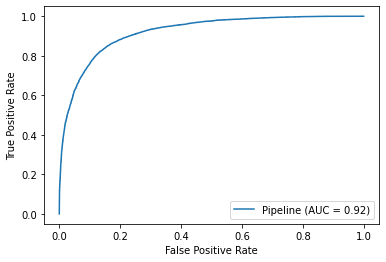

In [ ]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(cat_model, X_train, y_train_seasonal)

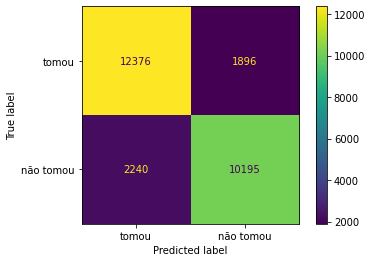

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(cat_model, X_train, y_train_seasonal, values_format='d', display_labels=['tomou', 'não tomou'])

In [ ]:
y_pred = cat_model.predict(X_train)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

accuracy_oot  = accuracy_score(y_train_seasonal, y_pred)
precision_oot = precision_score(y_train_seasonal, y_pred)
recall_oot    = recall_score(y_train_seasonal, y_pred)
f1_oot        = f1_score(y_train_seasonal, y_pred)

print(f"Accuracy OOT: {accuracy_oot:.3f}")
print(f"Precision OOT: {precision_oot:.3f}")
print(f"Recall OOT: {recall_oot:.3f}")
print(f"F1: {f1_oot:.3f}")

Accuracy OOT: 0.845
Precision OOT: 0.843
Recall OOT: 0.820
F1: 0.831


     |████████████████████████████████| 356 kB 7.3 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491647 sha256=c1aa101be345dafb150b2513f860e6ce46d445b5febccf228303fd9315dc1f11
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


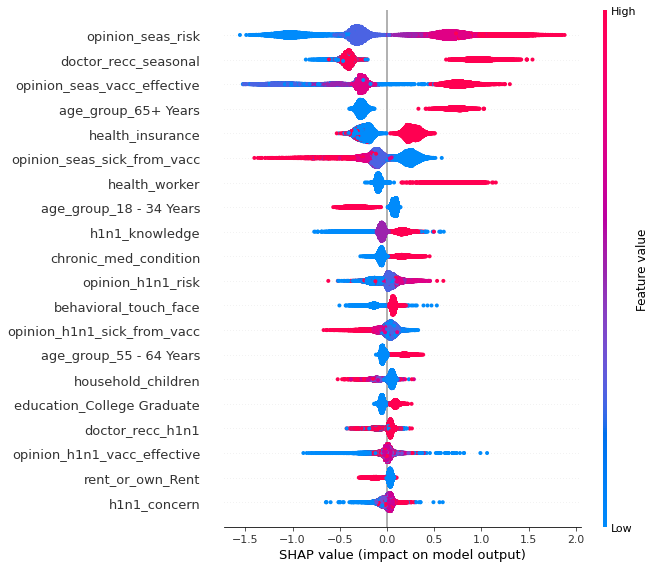

In [ ]:
# !pip install shap
import shap
explainer = shap.TreeExplainer(cat_model[-1])
X_train_transformado = cat_model[:-1].transform(X_train)
shap_values = explainer.shap_values(X_train_transformado)
shap.summary_plot(shap_values, X_train_transformado)

In [ ]:
y_pred_test = cat_model.predict(X_test)
y_pred_test

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
y_proba_test = cat_model.predict_proba(X_test)[:,1]
y_proba_test = pd.DataFrame(y_proba_test, columns=['seasonal_vaccine'])
y_proba_test.head()

,seasonal_vaccine
0,0.185570
1,0.022953
2,0.783317
3,0.899506
4,0.500248


In [ ]:
respondent_id_test = pd.DataFrame(test_set_features['respondent_id'], columns=['respondent_id'])
type(respondent_id_test)

pandas.core.frame.DataFrame

In [ ]:
respondent_id_test.shape, y_proba_test.shape

((26708, 1), (26708, 1))

In [ ]:
pred_seasonal = pd.concat([respondent_id_test, y_proba_test], axis=1, join="inner")
pred_seasonal.head()

,respondent_id,seasonal_vaccine
0,26707,0.185570
1,26708,0.022953
2,26709,0.783317
3,26710,0.899506
4,26711,0.500248


In [ ]:
pred_seasonal.to_csv('/content/drive/MyDrive/DrivenData/case_h1n1_flu/python/pred_seasonal.csv', index=False)

In [ ]:
pred_h1n1 = pd.read_csv('/content/drive/MyDrive/DrivenData/case_h1n1_flu/python/pred_h1n1.csv')
pred_h1n1.head()

,respondent_id,h1n1_vaccine
0,26707,0.119819
1,26708,0.044830
2,26709,0.221822
3,26710,0.616064
4,26711,0.233779


In [ ]:
# criando histórico da abt de treino - apenas 1 safra
submission_df = (
    pred_h1n1
    .merge(pred_seasonal, on='respondent_id', how='inner')
)
submission_df.tail()

,respondent_id,h1n1_vaccine,seasonal_vaccine
26703,53410,0.281229,0.460878
26704,53411,0.191828,0.224976
26705,53412,0.167452,0.179251
26706,53413,0.009764,0.336977
26707,53414,0.502808,0.626342


In [ ]:
submission_df.to_csv('/content/drive/MyDrive/DrivenData/case_h1n1_flu/python/submission_df.csv', index=False)

In [4]:
pd.__version__

'1.1.5'